In [1]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal

from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
seed=2023

In [2]:
def get_fr_df(filepath,in_out,cgroup,e_align):
    print(filepath)
    py_f = np.load(filepath,allow_pickle=True).item(0)
    sp = py_f['sp_data']
    bhv = py_f['bhv']
    trial_idx = select_trials.select_trials_block(sp, n_block=1)
    trial_idx = select_trials.select_correct_trials(bhv, trial_idx)
    task = def_task.create_task_frame(trial_idx, bhv, task_constants.SAMPLES_COND)
    neurons = np.where((sp["clustersgroup"] == cgroup))[0]
    fr_samples = firing_rate.fr_by_sample_neuron(
            sp=sp,
            neurons=neurons,
            task=task,
            in_out=in_out,
            kernel=0,
            e_align=e_align,
            plot=False
        )
    return fr_samples

In [17]:
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_decoding.txt", "r")
Lines = file1.readlines()

In [19]:
"""for n,samplee in enumerate(fr_samples):
    samplee['day']=[n]*len(samplee)
pd.concat(fr_samples).replace(np.nan,0).to_csv("/home/INT/losada.c/Documents/data/res/fr_samples_lip.csv")"""

In [51]:
cgroup = "good"
in_out=1
e_align=2
win_size = 100
step = 10
fix_duration = 200
sample_duration = 450
fr_samples=[]
max_n_trials = []
num_neurons = 0
for line in Lines:
    path = line.strip()
    print(path)
    df= get_fr_df(path,in_out,cgroup,e_align=2)
    rolling_df = df.loc[:,:'neuron'].iloc[:,:-1].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
    rolling_df_sample = rolling_df.iloc[:,int((df['sample_on'][0]-fix_duration)/step):int((df['sample_on'][0]+sample_duration)/step)]
    df= get_fr_df(path,in_out,cgroup,e_align=4)
    rolling_df = df.loc[:,:'neuron'].iloc[:,:-1].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
    rolling_df_test = rolling_df.iloc[:,int((df['test_on_1'][0]-400)/step):]#int((df['test_on_1'][0]+2500)/step)
    rolling_df = pd.concat([rolling_df_sample,rolling_df_test],axis=1)
    rolling_df.columns = np.arange(rolling_df.shape[1])
    rolling_df = pd.concat([rolling_df,df[['neuron','sample','trial_idx']]],axis=1)
    # max number of trials that can be used 
    max_n_trials.append(rolling_df[['neuron','sample']][rolling_df['neuron']==1].groupby(['sample']).count().min()[0])
    # rename neurons
    unique_neurons = rolling_df['neuron'].unique()
    rolling_df['neuron'].replace(unique_neurons,np.arange(num_neurons,num_neurons+len(unique_neurons)),inplace=True)
    num_neurons += len(unique_neurons)
    # rename trials
    unique_trials = rolling_df['trial_idx'].unique()
    rolling_df['trial_idx'].replace(unique_trials,np.arange(len(unique_trials)),inplace=True)
    fr_samples.append(rolling_df)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy
Number of trials in block 1: 1308
Number of correct trials in block 2: 574
Number of trials in block 1: 1308
Number of correct trials in block 2: 574
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/lip/2022-12-14_10-50-49_Riesling_lip_e1_r1.npy
Number of trials in block 1: 1753
Number of correct trials in block 2: 874
Number of trials in block 1: 1753
Number of correct trials in block 2: 874
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/lip/2022-11-28_10-23-27_Riesling_lip_e1_r1.npy
Number of trials in block 1: 1536
Number of correct trials in block 2: 657
Number of trials in block 1: 1536
Number of correct trials in block 2: 657
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/lip/2022-12-16_10-30-59_Riesling_lip_e1_r1.npy
Number of trials in block 1: 1340
Number of correct trials in bloc

In [18]:
# load all pfc files
paths=[]
for line in Lines:
    paths.append(line.strip())
    
cgroup = "good"
in_out=1
e_align=2
win_size = 100
step = 10
fix_duration = 200
sample_duration = 450
fr_samples=[]
max_n_trials = []
num_neurons = 0
def load_fr_samples(path:str,n:int):
    df= get_fr_df(path,in_out,cgroup,e_align=2)
    rolling_df = df.loc[:,:'neuron'].iloc[:,:-1].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
    rolling_df_sample = rolling_df.iloc[:,int((df['sample_on'][0]-fix_duration)/step):int((df['sample_on'][0]+sample_duration)/step)]
    df= get_fr_df(path,in_out,cgroup,e_align=4)
    rolling_df = df.loc[:,:'neuron'].iloc[:,:-1].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
    rolling_df_test = rolling_df.iloc[:,int((df['test_on_1'][0]-400)/step):]#int((df['test_on_1'][0]+2500)/step)
    rolling_df = pd.concat([rolling_df_sample,rolling_df_test],axis=1)
    rolling_df.columns = np.arange(rolling_df.shape[1])
    rolling_df = pd.concat([rolling_df,df[['neuron','sample','trial_idx']]],axis=1)
    return rolling_df

with Pool(5) as pool:
    async_fr = [pool.apply_async(load_fr_samples,args=(paths[n],n)) for n in np.arange(len(paths))] 
    fr_roll = [asc.get() for asc in async_fr]




/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-12-14_10-50-49_Riesling_pfc_e1_r1.npy/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-11-28_10-23-27_Riesling_pfc_e1_r1.npy/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-11-22_10-59-03_Riesling_pfc_e1_r1.npy/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-12-16_10-30-59_Riesling_pfc_e1_r1.npy/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-11-30_10-42-03_Riesling_pfc_e1_r1.npy




Number of trials in block 1: 1308
Number of correct trials in block 2: 574
Number of trials in block 1: 1340
Number of correct trials in block 2: 582
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-11-22_10-59-03_Riesling_pfc_e1_r1.npy
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/Session_struct/pfc/2022-12-16_10-30-59_Riesling_pfc_e1_r1.npy
Num

In [19]:
for rolling_df in fr_roll:
    # max number of trials that can be used 
    max_n_trials.append(rolling_df[['neuron','sample']][rolling_df['neuron']==1].groupby(['sample']).count().min()[0])
    # rename neurons
    unique_neurons = rolling_df['neuron'].unique()
    rolling_df['neuron'].replace(unique_neurons,np.arange(num_neurons,num_neurons+len(unique_neurons)),inplace=True)
    num_neurons += len(unique_neurons)
    # rename trials
    unique_trials = rolling_df['trial_idx'].unique()
    rolling_df['trial_idx'].replace(unique_trials,np.arange(len(unique_trials)),inplace=True)
    fr_samples.append(rolling_df)

### SVM2

In [20]:
def sample_df(fr_samples,seed):
    all_df = []
    for fr_s in fr_samples: #days
        for i_sample in fr_s['sample'].unique():
            n_df = fr_s[fr_s['sample']==i_sample]
            sam_df = n_df[n_df['neuron']==n_df['neuron'].iloc[0]].sample(min(max_n_trials),random_state=seed).reset_index(drop=True)[['sample','trial_idx']]
            sam_df = pd.merge(fr_s, sam_df,on=['sample','trial_idx'], how="inner")
            sam_df['trial_idx'].replace(sam_df['trial_idx'].unique(),np.arange(0,min(max_n_trials)),inplace=True)
            all_df.append(sam_df)
    all_df = pd.concat(all_df)
    all_df = all_df.replace(np.nan,0)
    return all_df

In [21]:
def compute_window_matrix(all_df,n_win):
    y,all_samples = [], []
    for i_sample in all_df['sample'].unique():
        n_df = all_df[all_df['sample']==i_sample]
        data = n_df[[n_win,'neuron','trial_idx']]
        n_pivot = pd.pivot_table(data, values=n_win,index='trial_idx',columns='neuron').reset_index(drop=True)#.loc[:,0:]
        all_samples.append(n_pivot)
        y.append([i_sample]*min(max_n_trials))
    return pd.concat(all_samples).reset_index(drop=True),np.concatenate(y)

In [22]:
def run_svm_decoder(model,fr_samples,windows,it_seed,n_it,le):
    scores = np.zeros((windows))
    all_df= sample_df(fr_samples,it_seed[n_it])
    all_df['sample']=le.transform(all_df['sample'])
    for n_win in np.arange(0,windows):
        #  select trials randomly
        X,y = compute_window_matrix(all_df,n_win)
        # split in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it],stratify=y)
        X_train['label_encoder'] = y_train
        # Sample with replacement (only train set)
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=True)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        scores[n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [23]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

In [24]:
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)

In [25]:
le = LabelEncoder()
le.fit(pd.concat(fr_samples)['sample'].unique())
#all_df['sample']=le.transform(all_df['sample'])
n_iterations = 10
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows=354#0
with Pool(10) as pool:
    async_scores = [pool.apply_async(run_svm_decoder,args=(model,fr_samples,windows,it_seed,n,le)) for n in np.arange(n_iterations)] 
    scores2 = [asc.get() for asc in async_scores]

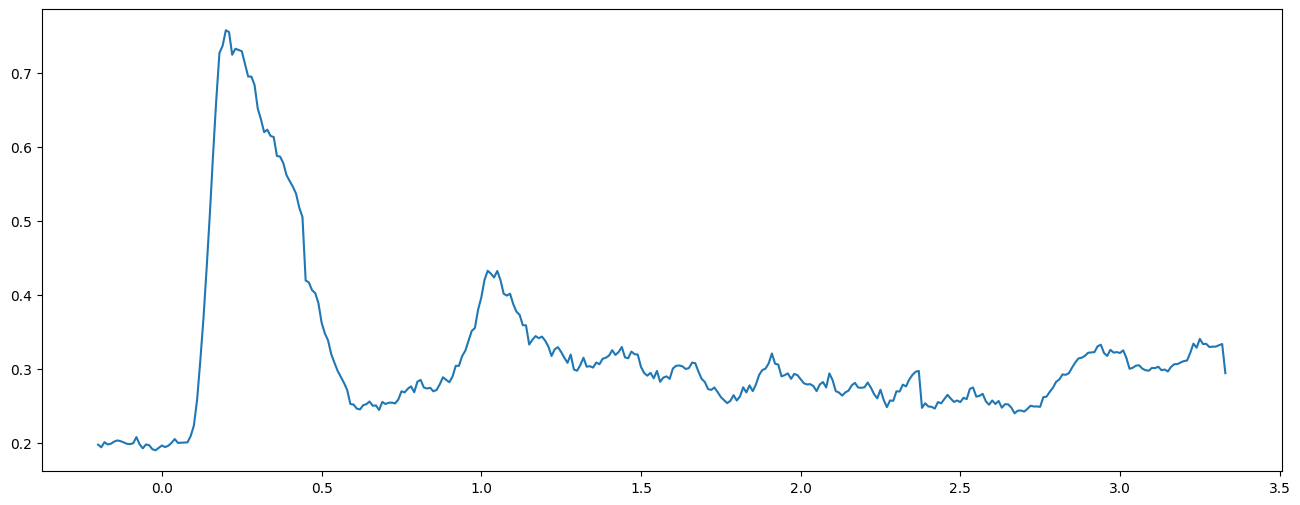

In [ ]:
# good 1
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration/10)/100,np.array(scores2).mean(axis=0))

Text(0.5, 0.98, 'V4')

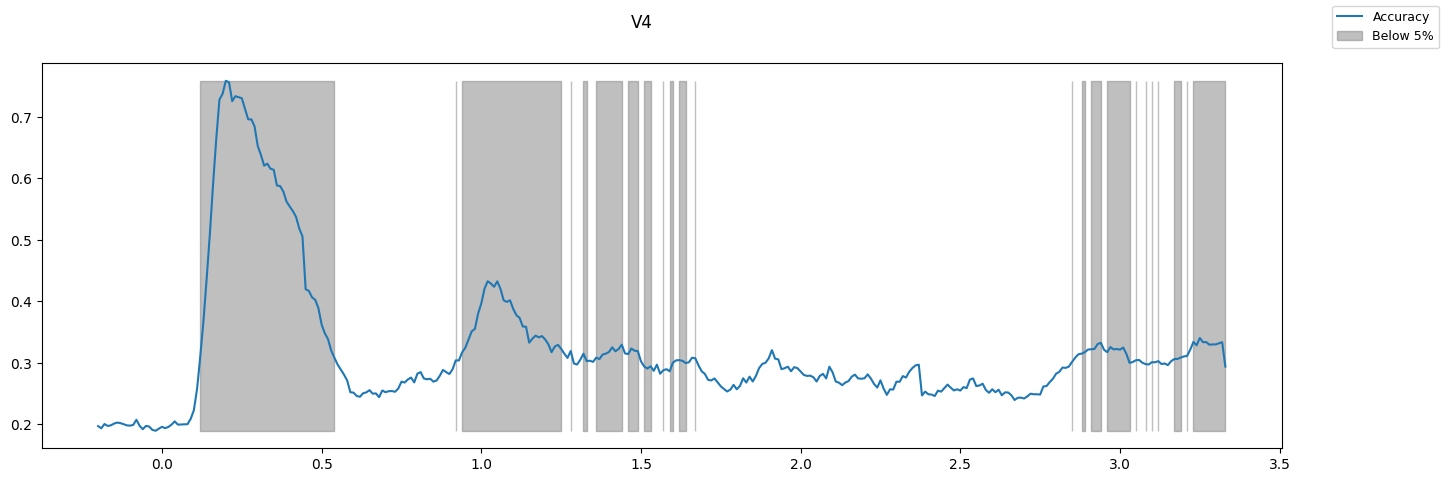

In [16]:
fig,ax = plt.subplots(figsize=(16,5))
x = ((np.arange(0,len(scores2[0])))-fix_duration/10)/100
ax.plot(x,np.array(scores2).mean(axis=0),label='Accuracy')
ss = np.sum(np.array(scores2)<0.2,axis=0)/np.array(scores2).shape[0]
mask_inf = ss<=0.05
mask_sup = ss>0.05
ax.fill_between(x,y1=min(np.array(scores2).mean(axis=0)),y2=max(np.array(scores2).mean(axis=0)),where=ss<=0.05,color='grey',alpha=0.5,label='Below 5%')
#ax.scatter(x[mask_inf],(ss)[mask_inf],color='k',marker='.',label='Below 5%')
#ax.scatter(x[mask_sup],(ss)[mask_sup],color='grey',marker='.',label='Above 5%')
fig.legend(fontsize=9)
fig.suptitle("PFC")


### SVM

In [ ]:
def compute_window_matrix(all_df,n_win,seed):
    y,all_samples = [], []
    for i_sample in all_df['sample'].unique():
        n_df = all_df[all_df['sample']==i_sample]
        data = n_df[[n_win,'neuron','trial_idx']]
        n_pivot = pd.pivot_table(data, values=n_win,index='trial_idx',columns='neuron').reset_index(drop=True).loc[:,0:]
        sample_df = []    
        for n in np.arange(len(n_pivot.columns)):
            sample_df.append(n_pivot.loc[~n_pivot[n].isna(),n].sample(min(max_n_trials),random_state=seed).reset_index(drop=True))
        all_samples.append(pd.concat(sample_df,axis=1))
        y.append([i_sample]*min(max_n_trials))
    return pd.concat(all_samples),np.concatenate(y)


In [ ]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

In [ ]:
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)

In [ ]:
def run_svm_decoder(model,all_df,windows,it_seed,n_it):
    scores = np.zeros((windows))
    #for n_it in np.arange(n_iterations):       
    for n_win in np.arange(0,windows):
        #  select trials randomly
        X,y = compute_window_matrix(all_df,n_win,it_seed[n_it])
        # split in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
        X_train['label_encoder'] = y_train
        # Sample with replacement (only train set)
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=True)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        scores[n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [ ]:
all_df=all_df.replace(np.nan,0)

In [ ]:
le = LabelEncoder()
le.fit(all_df['sample'].unique())
all_df['sample']=le.transform(all_df['sample'])
n_iterations = 1000
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows=354#0
with Pool(9) as pool:
    async_scores = [pool.apply_async(run_svm_decoder,args=(model,all_df,windows,it_seed,n)) for n in np.arange(n_iterations)] 
    scores2 = [asc.get() for asc in async_scores]

In [ ]:
# good 1
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration/10)/100,np.array(scores2).mean(axis=0))

In [ ]:
# mua 100
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))

In [ ]:
# good 10
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))

In [ ]:
# all 10
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))